In [44]:
## Compare parameter values for EKI and history matching at iteration 1
import os
import glob
import csv

import sys
sys.path.insert(0,'../../History-Matching-Core/src/')

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from cmcrameri import cm
plt.rcParams.update({'font.size': 22})

In [2]:
from history_matching.emulator import GPEmulator, implausibility

In [5]:
## Create array
n_its = 6
N = 50
basedir = os.environ['GROUP_SCRATCH']+f"/EKI_N{N}/"
plotdir = f"{basedir}/PLOTS/"

params_files = [f"{basedir}/iteration_{n}/paramlist.csv" for n in range(0,n_its+1)]
params = [np.genfromtxt(params_file, delimiter=',', skip_header=1) for params_file in params_files]


param_arr = np.zeros((n_its+1, N, 2))
for i in range(n_its+1):
    param_arr[i] = params[i][:, 1:]

iter_ind = np.arange(n_its+1)

In [6]:
param_arr.shape, iter_ind.shape

((7, 50, 2), (7,))

In [8]:
## QBO files
QBO_dir = [f"{basedir}/iteration_{n}/" for n in range(0,n_its+1)]
QBO_arr = np.zeros((n_its, N, 2))
QBO_err = np.zeros((n_its, N, 2))

for i in range(n_its):
    for j in range(N):
        QBO_file = f"{QBO_dir[i]}{j}/QBO_TT_metrics.csv"
        QBO_vals = np.genfromtxt(QBO_file, delimiter=',', skip_header=1)
        QBO_arr[i, j] = QBO_vals[1:3]
        QBO_err[i, j] = QBO_vals[[3, 6]]


In [9]:
## Get QBO truth
truthdir = "/home/users/lauraman/EKI_OBS/ground_truth_data"
truth_filename = "QBO_TT_metrics_ground_truth.csv"

filepath_truth = f"{truthdir}/{truth_filename}"
QBO_truth = np.genfromtxt(filepath_truth, delimiter=',', skip_header=1)

In [10]:
QBO_period_truth = QBO_truth[1]
QBO_amp_truth = QBO_truth[2]
QBO_period_sd = np.sqrt(QBO_truth[3])
QBO_amp_sd = np.sqrt(QBO_truth[-1])

In [11]:
QBO_err.shape, QBO_arr.shape, param_arr.shape

((6, 50, 2), (6, 50, 2), (7, 50, 2))

In [31]:
Gamma_obs = np.array((QBO_truth[3:5],QBO_truth[5:7]))


In [12]:
it = 0
param_it = param_arr[it]
QBO_it = QBO_arr[it]
QBO_err_it = QBO_err[it]


In [13]:
param_it.shape, QBO_it.shape, QBO_err_it.shape

((50, 2), (50, 2), (50, 2))

In [14]:
emulator = GPEmulator()


In [15]:
emulator.fit(param_it, QBO_it, QBO_err_it)

In [16]:
emulator

GPEmulator()

In [17]:
## Create grid of parameter space:
N = 100
cw = np.linspace(0., 80, N)
Bt = np.linspace(0, 0.008, N)
cwgrid, Btgrid = np.meshgrid(cw , Bt)

In [18]:
params = np.vstack((cwgrid.flatten(), Btgrid.flatten()))

In [19]:
params.shape

(2, 10000)

In [20]:
emulator_values = emulator.predict(params.T)

In [21]:
period = emulator_values[:, 0].reshape((N,N))
amp = emulator_values[:, 1].reshape((N,N))


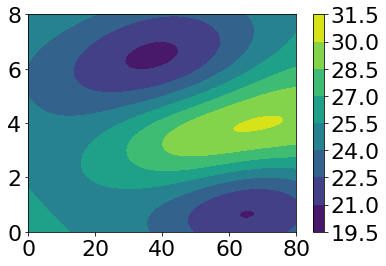

In [22]:
plt.contourf(cwgrid, Btgrid*1e3, period)
plt.colorbar()

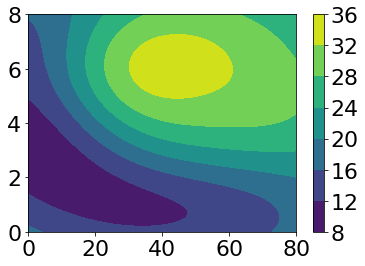

In [23]:
plt.contourf(cwgrid, Btgrid*1e3, amp)
plt.colorbar()

In [49]:
## Log likelihood
def log_likelihood(y_pred, truth):
    LL = - np.sum((( y_pred - truth ).T  *  np.linalg.inv(Gamma_obs) * (y_pred - truth) / 2.))
    return LL

In [52]:
truth_values = np.array([QBO_period_truth, QBO_amp_truth])
log_likelihood_values = np.zeros(emulator_values.shape[0])
for i in range(emulator_values.shape[0]):
    log_likelihood_values[i]=log_likelihood(emulator_values[i,:], truth_values)

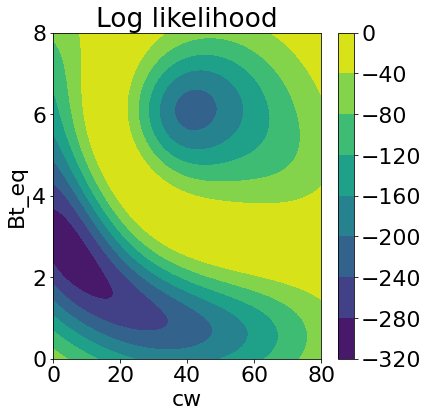

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

plt.contourf(cwgrid, Btgrid*1e3, log_likelihood_values.reshape((N,N)))
plt.xlabel("cw")
plt.ylabel("Bt_eq")
plt.title("Log likelihood")
plt.colorbar()